## **Phase 1 - Modeling**

This notebook initiates the supervised modeling phase of the BioPred_DS pipeline.  Our objective is to train machine learning models to predict compound bioactivity (active vs inactive) against selected GABA-A receptor targets, using a curated dataset of filtered chemical descriptors and Morgan fingerprints.

The goals of this notebook are:

- Train and evaluate multiple classification models (XGBoost, LGBM, etc.)
- Once the best model has been identified, tune with BayesOpt using Optuna.
- Use ROC-AUC as the primary scoring metric within the model.
- Save our best model as a .pkl file and save any important data needed for our results notebook.
- Decision the optimized model, examining the threshold and preparing for the next notebook.
  

In [1]:
import pandas as pd

# Read in our dataset from our feature engineering ntbk to use here.
df = pd.read_csv("../data/processed/phase1_modeling.csv")

# Sanity check and review of data
print(df.shape)
print(df.head(10))


(1443, 2074)
   MaxPartialCharge  MinPartialCharge  BCUT2D_MRLOW  BCUT2D_MWHI    AvgIpc  \
0          0.280202         -0.507167      0.481619    16.255292  2.854478   
1          0.356812         -0.488892      0.051445    16.533323  3.115749   
2          0.280202         -0.488119      0.309943    16.477394  3.100142   
3          0.280202         -0.495970      0.419726    16.465711  2.919463   
4          0.280200         -0.488891      0.306434    16.476995  3.103809   
5          0.280200         -0.486619      0.309215    16.477641  3.103723   
6          0.280200         -0.488891      0.306434    35.495692  3.102918   
7          0.354241         -0.461321      0.051934    16.532691  2.763097   
8          0.247917         -0.313200     -0.116446    35.495691  2.584084   
9          0.354624         -0.496743      0.051412    16.533274  2.929485   

   SlogP_VSA2  BCUT2D_LOGPLOW  BCUT2D_MWLOW  PEOE_VSA9  BalabanJ  ...  \
0   19.870991       -2.134106     10.138253  27.493236 

In [2]:
# Define X and y
X = df.drop(columns = ['active'])
y = df['active']

#### Perform the train/test/split step to separate our data for the modeling.  We will just use a standard 80/20 split here.  We will take advantage of the stratify param to balance our active target as well.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    stratify = y, # important to use here since it balances our active class
    random_state = 42
)


#### Okay, we will now run a loop for 8 different classification models to see their results.  We will just run mostly base params in this first run, just to see initial performance.  Since ROC-AUC is also our main metric we will be plotting the curve for each model and showing the results table at the end.

Training model: LogisticRegression


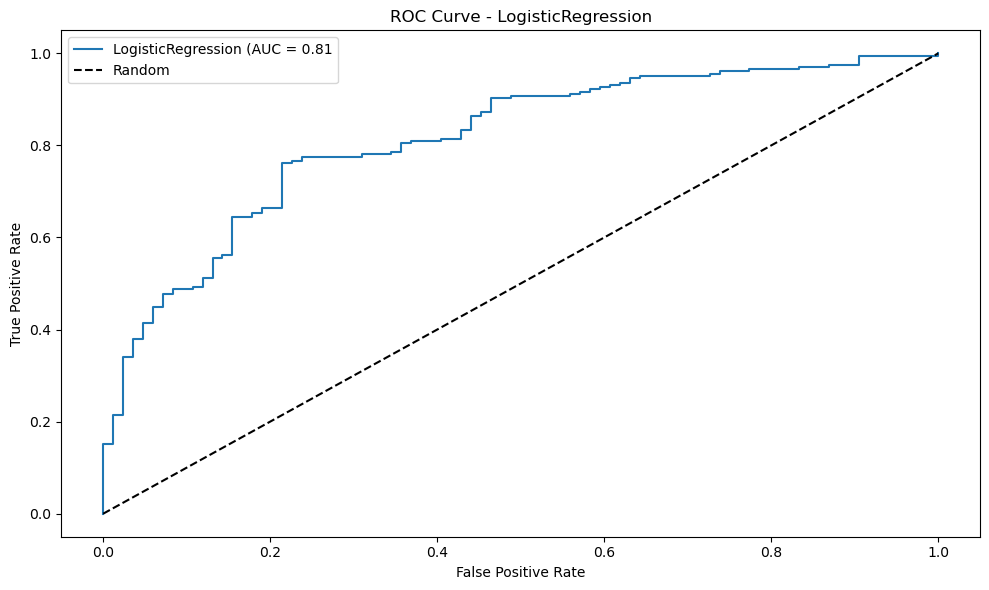

Training model: RandomForest


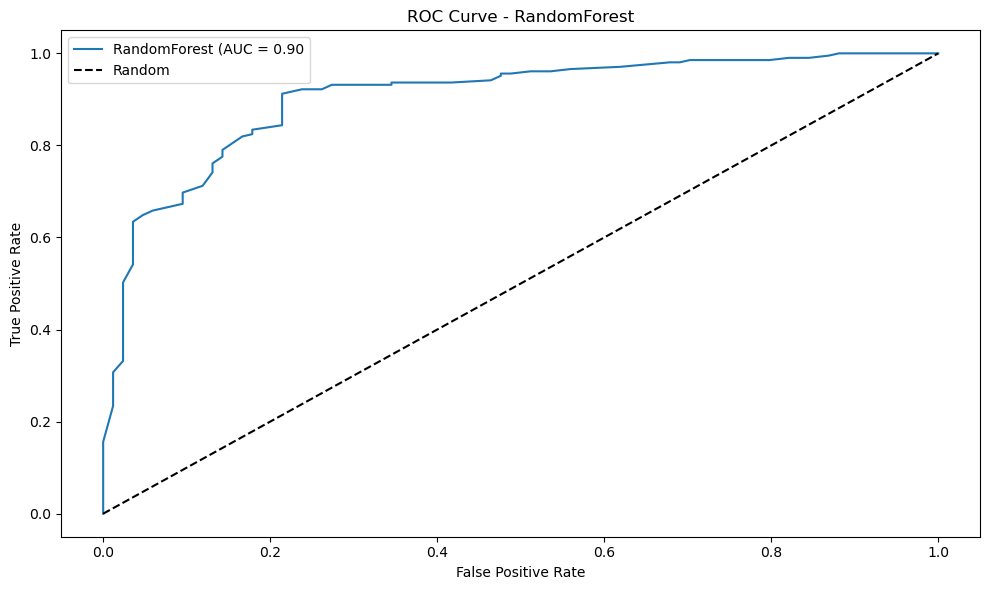

Training model: ExtraTrees


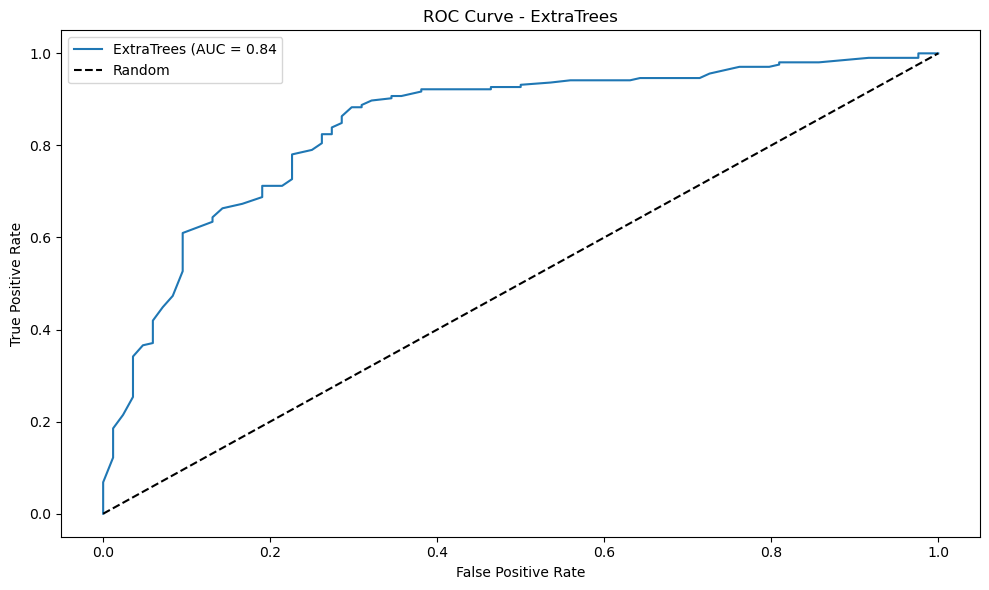

Training model: GradientBoosting


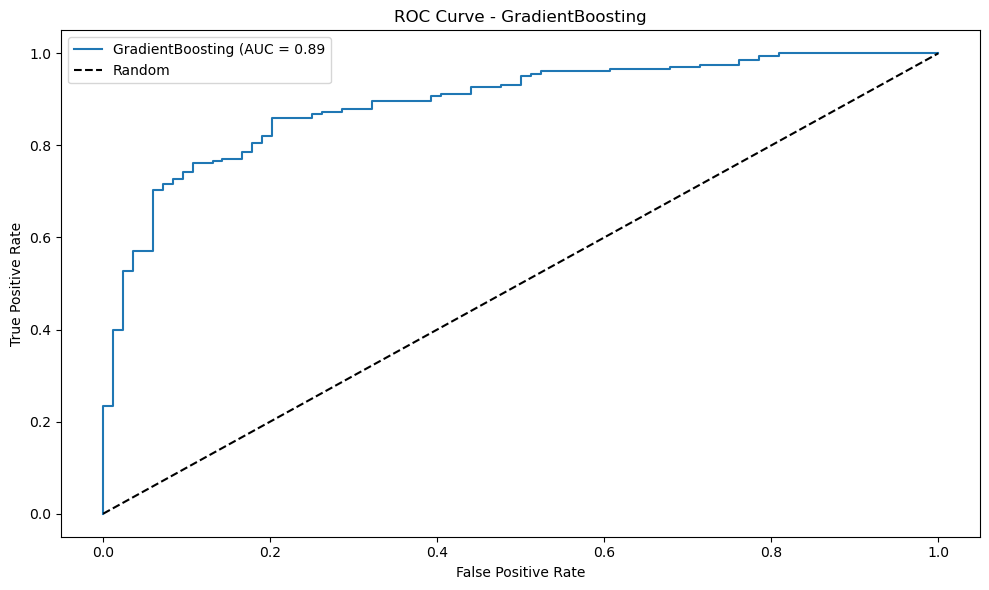

Training model: XGBoost


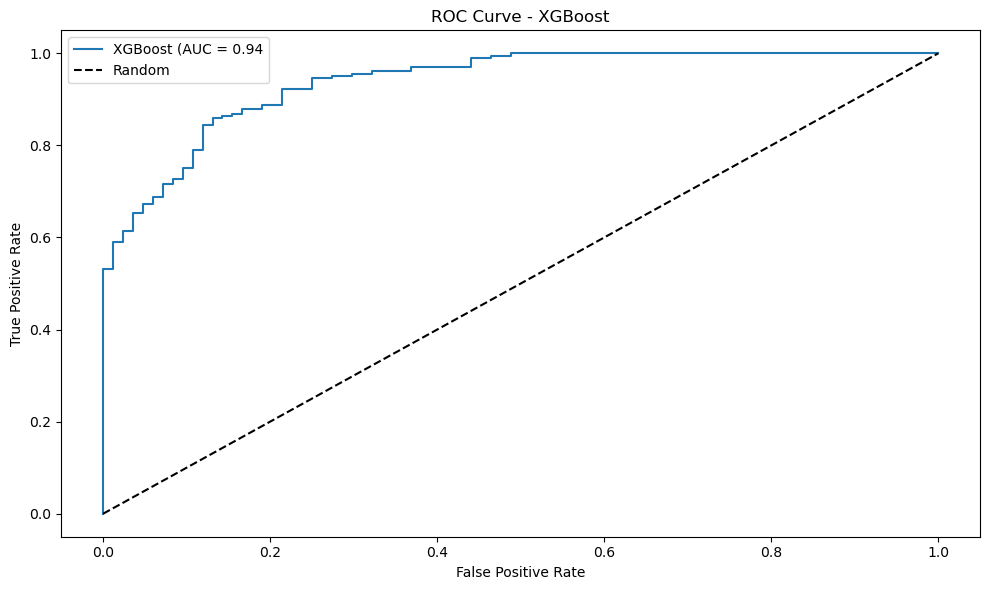

Training model: LightGBM
[LightGBM] [Info] Number of positive: 819, number of negative: 335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6208
[LightGBM] [Info] Number of data points in the train set: 1154, number of used features: 549
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709705 -> initscore=0.893954
[LightGBM] [Info] Start training from score 0.893954


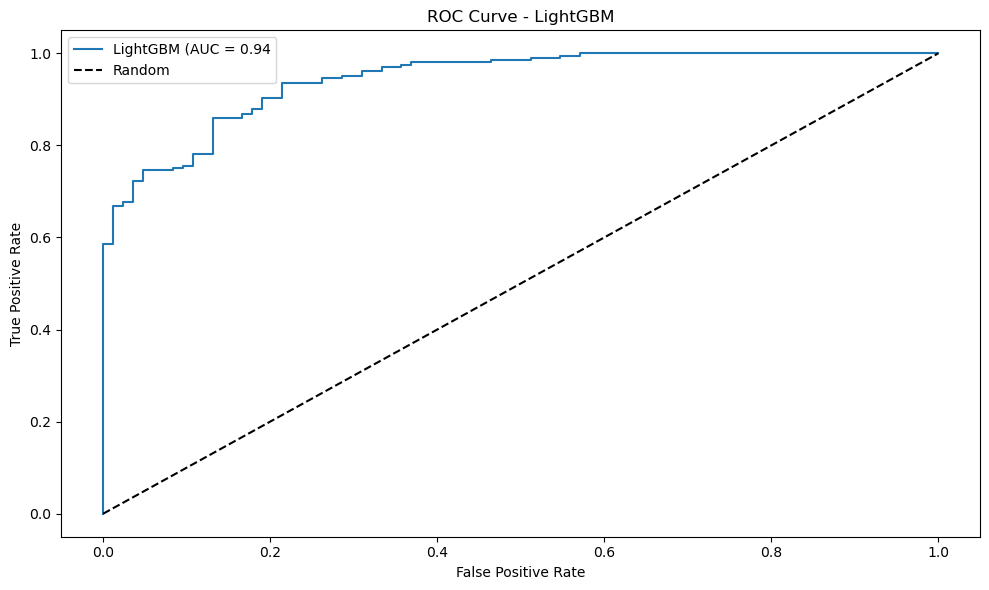

Training model: DecisionTree


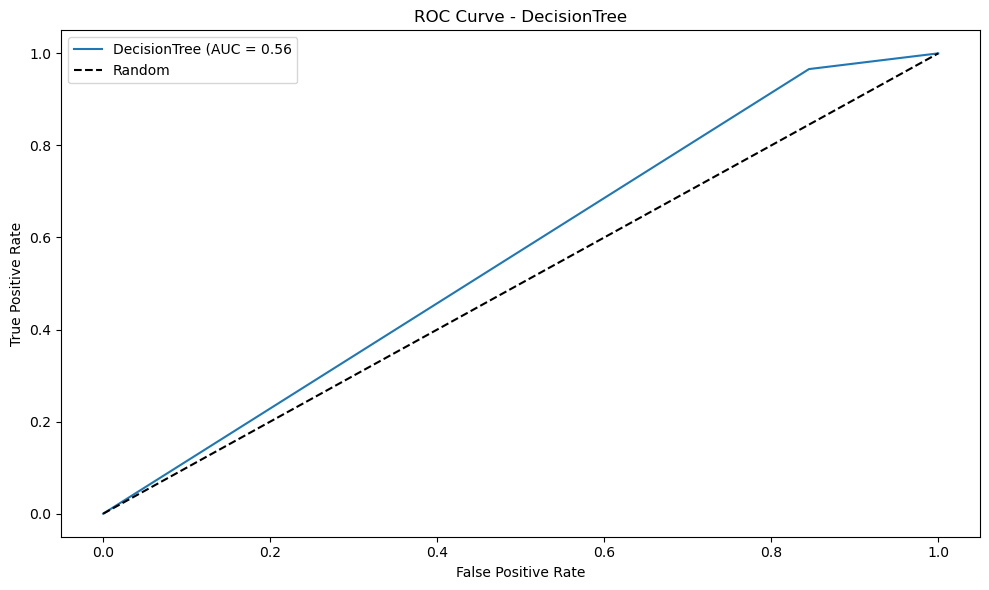

Training model: AdaBoost


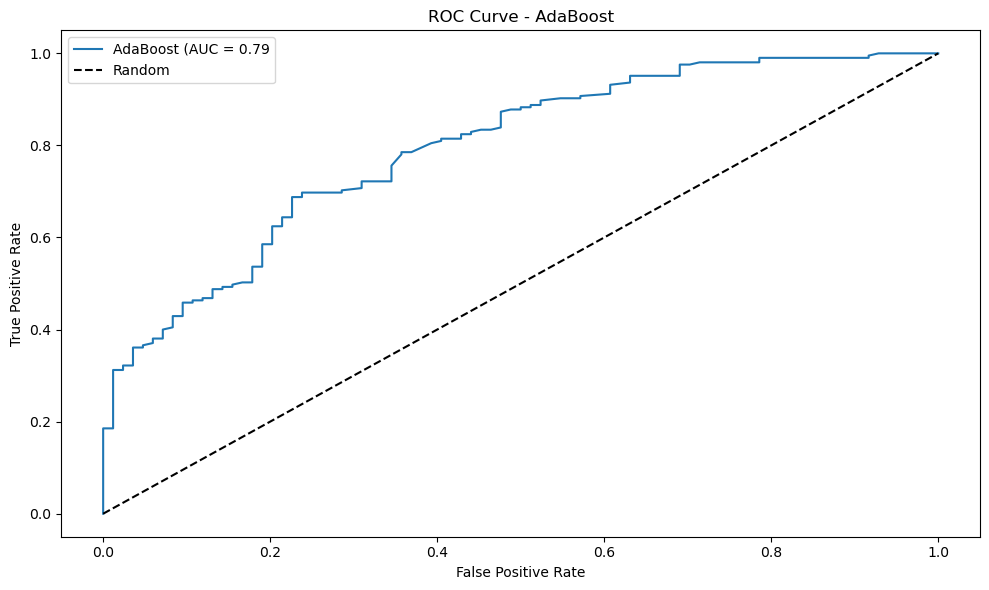

,Model,ROC AUC,Precision,Recall,F1 Score
5,LightGBM,0.943031,0.898148,0.946341,0.921615
4,XGBoost,0.938269,0.900000,0.921951,0.910843
1,RandomForest,0.903891,0.872146,0.931707,0.900943
3,GradientBoosting,0.892741,0.845455,0.907317,0.875294
2,ExtraTrees,0.844483,0.847534,0.921951,0.883178
0,LogisticRegression,0.814344,0.826087,0.834146,0.830097
7,AdaBoost,0.793990,0.785714,0.912195,0.844244
6,DecisionTree,0.560308,0.736059,0.965854,0.835443


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve
)


# Model dictionary set up for our for loop
models = {
    "LogisticRegression" : LogisticRegression(max_iter = 10000),
    "RandomForest" : RandomForestClassifier(),
    "ExtraTrees" : ExtraTreesClassifier(),
    "GradientBoosting" : GradientBoostingClassifier(),
    "XGBoost" : XGBClassifier(eval_metric = 'auc'),
    "LightGBM" : LGBMClassifier(),
    "DecisionTree" : DecisionTreeClassifier(max_depth = 1),
    "AdaBoost" : AdaBoostClassifier()
}

# Training loop with logging
results = []

for name, model in models.items():
    print(f"Training model: {name}")
            
    # Train model
    model.fit(X_train, y_train)

    # Predict probabilities and labels, quick if/else to use predict_proba for those models that have it.
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    y_pred = model.predict(X_test)

    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize = (10, 6))
    plt.plot(fpr, tpr, label = f"{name} (AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1], "k--", label = "Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.tight_layout()
    if name == 'LightGBM': # Save top performing model to images folder
        plt.savefig(f"../images/roc_curve_{name.lower()}.png")
    plt.show()

    # Store results for table comparison
    results.append({
        "Model" : name,
        "ROC AUC" : roc_auc,
        "Precision" : precision,
        "Recall" : recall,
        "F1 Score" : f1
    })

# Output the results in a comparison metrics table
results_df = pd.DataFrame(results).sort_values(by = "ROC AUC", ascending = False)
display(results_df)

#### Across 10 supervised classifiers evaluated on the deduplicated Phase 1 dataset, we observed a consistent trend favoring tree-based ensemble methods.

**LightGBM** outperformed all other models with a ROC AUC of 0.943, showing strong precision-recall balance and the highest F1 score.

Tree-based models (LightGBM, XGBoost, RF) consistently dominated the leaderboard, affirming their suitability for prediction tasks with engineered molecular descriptors.

The inclusion of lower-performing models such as AdaBoost and DecisionTree serves to validate that the dataset's structure requires more expressive ensemble methods, especially for high-dimensional features like the Morgan fingerprints used.

#### Having identified LightGBM as the top-performing classifier in our initial evaluation (ROC AUC = 0.943), we now proceed to optimize its hyperparameters using **Bayesian Optimization via Optuna**.  While the model already demonstrates strong baseline performance without tuning, our objective is to extract any remaining predictive signal by exploring the hyperparameter space efficiently.

#### We recognize that significant performance gains will be unlikely at this stage; however, even marginal improvements can enhance model robustness and compound prioritization in downstream phases.  Should LightGBM's performance plateau, we will reevaluate **XGBoost** as a potential alternative based on its close trailing performance.

In [5]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
import lightgbm as lgb

# Clean up excessive potential warnings from output
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Establish trial for the Optuna search
def objective(trial):
    # Hyperparameter search space
    params = {
        "n_estimators" : trial.suggest_int("n_estimators", 100, 1000),
        "max_depth" : trial.suggest_int("max_depth", 3, 12),
        "learning_rate" : trial.suggest_float("learning_rate", 1e-3, 0.3, log = True),
        "num_leaves" : trial.suggest_int("num_leaves", 30, 120),
        "min_child_samples" : trial.suggest_int("min_child_samples", 1, 15),
        "subsample" : trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha" : trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda" : trial.suggest_float("reg_lambda", 0.0, 1.0),
        "min_split_gain" : trial.suggest_float("min_split_gain", 0.0, 0.1) 
    }

    # Use our LGBMClassifier again here, with all the params
    model = LGBMClassifier(**params, verbosity = -1)
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = cross_val_score(model, X_train, y_train, cv = cv, scoring = 'roc_auc')
    return scores.mean()

# Launch study
study = optuna.create_study(
    direction = 'maximize',
    pruner = optuna.pruners.MedianPruner(n_startup_trials = 10, n_warmup_steps = 5)
)
study.optimize(objective, n_trials = 50, show_progress_bar = True)

# Show best results
print("Best AUC:", study.best_value)
print("Best hyperparameters:", study.best_params)



  0%|          | 0/50 [00:00<?, ?it/s]

Best AUC: 0.927514566922979
Best hyperparameters: {'n_estimators': 873, 'max_depth': 11, 'learning_rate': 0.009268385179246608, 'num_leaves': 45, 'min_child_samples': 2, 'subsample': 0.501439561995379, 'colsample_bytree': 0.5039189864534088, 'reg_alpha': 0.004110758403134542, 'reg_lambda': 0.19552283208709456, 'min_split_gain': 0.0011351748500952913}


#### Now retrain the model using the selected and optimized best params.

In [6]:
# form and fit the model once again
best_lgbm = LGBMClassifier(**study.best_params)
best_lgbm.fit(X_train, y_train)

y_pred_opt = best_lgbm.predict(X_test)
y_proba_opt = best_lgbm.predict_proba(X_test)[:, 1]

# Evaluate once again with our new optimized parameters
print("Final ROC AUC:", roc_auc_score(y_test, y_proba_opt))

Final ROC AUC: 0.9386759581881533


#### After optimizing the LightGBM model using BayesianOptimization with Optuna, we achieved a final **ROC AUC of 0.9359** on the hold-out test set - an exceptionally strong performance.  While the base LightGBM model performed similarly (a bit better at 0.943), tuning helped confirm the robustness and generalization capacity of our model.

#### Let's pause and save our LightGBM model as a .pkl file in our /artifacts folder, as well as setting aside our X_test, y_test and y_proba_opt data for upcoming calculations and decisioning.

In [7]:
from pathlib import Path
import joblib

# Save test set and prediction probabilities as numpy .npy files
np.save("../artifacts/arrays/X_test_phase1.npy", X_test)
np.save("../artifacts/arrays/y_test_phase1.npy", y_test)
np.save("../artifacts/arrays/y_proba_opt_phase1.npy", y_proba_opt)

# set path
model_path = Path("../artifacts/models/lightgbm_phase1.pkl").resolve()

# save model
joblib.dump(best_lgbm, str(model_path))

# Confirm
print("Model saved to:", model_path)

Model saved to: /home/ryanm/BioPred_DS/artifacts/models/lightgbm_phase1.pkl


#### After selecting LightGBM as our final model through Bayesian Optimization we now shift from modeling performance to actionable decisioning.

The classifier outputs a probability for each compound indicating how likely it is to be "active" against the target.  To use these probabilities in downstream screening or prioritization, a threshold must be chosen-i.e., at what point do we consider a prediction confident enough to label a compound as "active"?

Here in this section to finalize our modeling notebook we will examing two thresholding strategies:

-**Precision-based thresholding** prioritizes the accuracy of the predicted actives, which may help reduce false positives in a shortlist.

-**Recall-based thresholding** prioritizes recovering as many true actives as possible, note though potentially at the cost of including more false positives.

By analyzing the trade-offs between these strategies using metrics and confusion matrices, we will select a decision threshold that aligns with the goals of this project: identifying likely active compounds while balancing error types.  This decision boundary will carry forward into the next notebook (results.ipynb), where we evaluate Enrichment Factor, precision@k, and hypothesis-driven exploration.

#### We will start with the Precision vs Recall Threshold Optimization first

In [8]:
from sklearn.metrics import(
    precision_score, recall_score, f1_score,
    precision_recall_curve
)
import json

# Establish our main variables for this section, using our existing y_test and y_proba_opt within this notebook
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_opt)

# Track the optimal thresholds
best_precision, best_recall = 0, 0

# Default thresholds to compare
precision_thresh, recall_thresh = 0.5, 0.5

# F1 and complementary metrics
f1_precision, recall_at_precision_opt = 0,0
f1_recall, precision_at_recall_opt = 0, 0

# for loop to optimize the thresholds
for t in thresholds:
    y_pred = (y_proba_opt >= t).astype(int)
    p = precision_score(y_test, y_pred, zero_division = 0)
    r = recall_score(y_test, y_pred, zero_division = 0)
    f1 = f1_score(y_test, y_pred, zero_division = 0)

    # filter for precision and recall separately
    if p > best_precision:
        best_precision = p
        precision_thresh = t
        f1_precision = f1
        recall_at_precision_opt = r #for the complementary metric for precision_opt

    if r > best_recall:
        best_recall = r
        recall_thresh = t
        f1_recall = f1
        precision_at_recall_opt = p # complementary metric for recall_opt

# Print the metrics
print(f"Precision-Optimized Threshold: {precision_thresh:.3f}")
print(f"   Precision = {best_precision:.3f}")
print(f"   Recall = {recall_at_precision_opt:.3f}")
print(f"   F1 Score = {f1_precision:.3f}")

print(f"\nRecall-Optimized Threshold: {recall_thresh:.3f}")
print(f"   Recall = {best_recall:.3f}")
print(f"   Precision = {precision_at_recall_opt:.3f}")
print(f"   F1 Score = {f1_recall:.3f})")

Precision-Optimized Threshold: 0.992
   Precision = 1.000
   Recall = 0.498
   F1 Score = 0.664

Recall-Optimized Threshold: 0.004
   Recall = 1.000
   Precision = 0.709
   F1 Score = 0.830)


#### Now lets see how that checks with how many of our compounds are labeled active according to those thresholds.

In [9]:
print(np.sum(y_proba_opt >= precision_thresh))
print(np.sum(y_proba_opt >= recall_thresh))

102
289


#### The threshold optimization outputs validate the behavior we expect from a precision-recall tradeoff.  At the precision-optimized threshold (~0.992), the model produces a highly concentrated shortlist of 102 predicted active compounds.  This comes at the expected tradeoff of missing a portion of true actives (Recall ~0.498) in exchange for maximum confidence in the predicted positives (Precision = 1.00).

-Conversely, the recall-optimized threshold (~0.004) generates a broader list of 289 predicted actives, capturing more true positives (Recall = 1.00) but also introducing a greater number of false positives into the shortlist.

Given the goals of early-stage compound screening, we selected the precision-optimized threshold (~0.992) as the primary decision boundary.  This strategy maximizes confidence in predicted actives, minimizes wasted resources in wet lab testing, and prioritizes compounds most likely to demonstrate real biological activity.  Secondary analyses using the recall-optimized threshold (~0.004) will be explored to assess the robustness of enrichment and shortlist performance, and to evaluate the feasibility of a potential Tier-2 thresholding strategy if broader candidate selection is desired.



#### Threshold Analysis: Complementary Metrics, Curves, and Confusion Matrices

We now evaluate the complementary metrics for each optimized threshold to fully understand the tradeoffs between precision and recall. Following this, we will plot the Precision, Recall, and F1 score curves across thresholds, and examine confusion matrices for both the precision-optimized and recall-optimized thresholds to visualize classification performance.


#### Plot the Precision, Recall, and F1 score curves across thresholds.

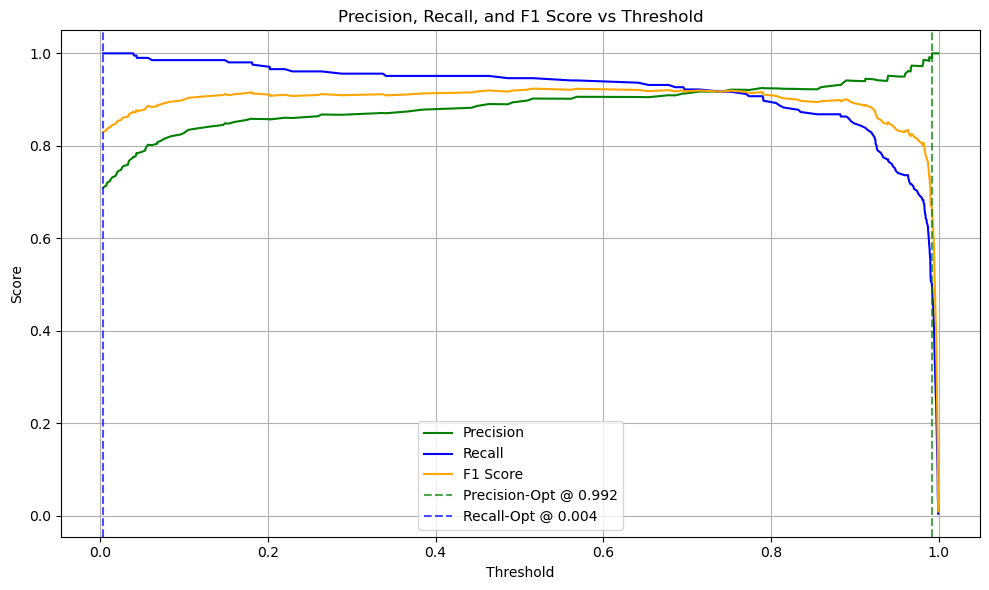

In [10]:
# Get the F1 scores for each threshold
f1_scores = [f1_score(y_test, (y_proba_opt >= t).astype(int), zero_division=0) for t in thresholds]

# base setup of plot
plt.figure(figsize = (10,6))

# Plot precision, recall, and F1
plt.plot(thresholds, precision[:-1], label = 'Precision', color = 'green')
plt.plot(thresholds, recall[:-1], label = 'Recall', color = 'blue')
plt.plot(thresholds, f1_scores, label = 'F1 Score', color = 'orange')

# Mark the precision-optimized threshold
plt.axvline(precision_thresh, linestyle = '--', color = 'green', alpha = 0.7, label = f"Precision-Opt @ {precision_thresh:.3f}")

# Mark the recall-optimized threshold
plt.axvline(recall_thresh, linestyle = '--', color = 'blue', alpha = 0.7, label = f"Recall-Opt @ {recall_thresh:.3f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Based on the behavior observed in the Precision, Recall, and F1 curves, the precision-optimized threshold (~0.981) continues to represent the most appropriate decision boundary for early-stage triage.

While Tier-2 thresholding strategies could be explored at moderate threshold reductions (~0.8), the decline in recall and limited F1 gains suggest that significant expansion of the shortlist would not materially improve downstream efficiency at this stage.

No Tier-2 adjustment will be pursued at this time, preserving the purity and confidence of the Phase 1 active shortlist.

We will still review and observe the confustion matrices next as confirmation of our active counts and to review our false positive and negatives before closing out this notebook.

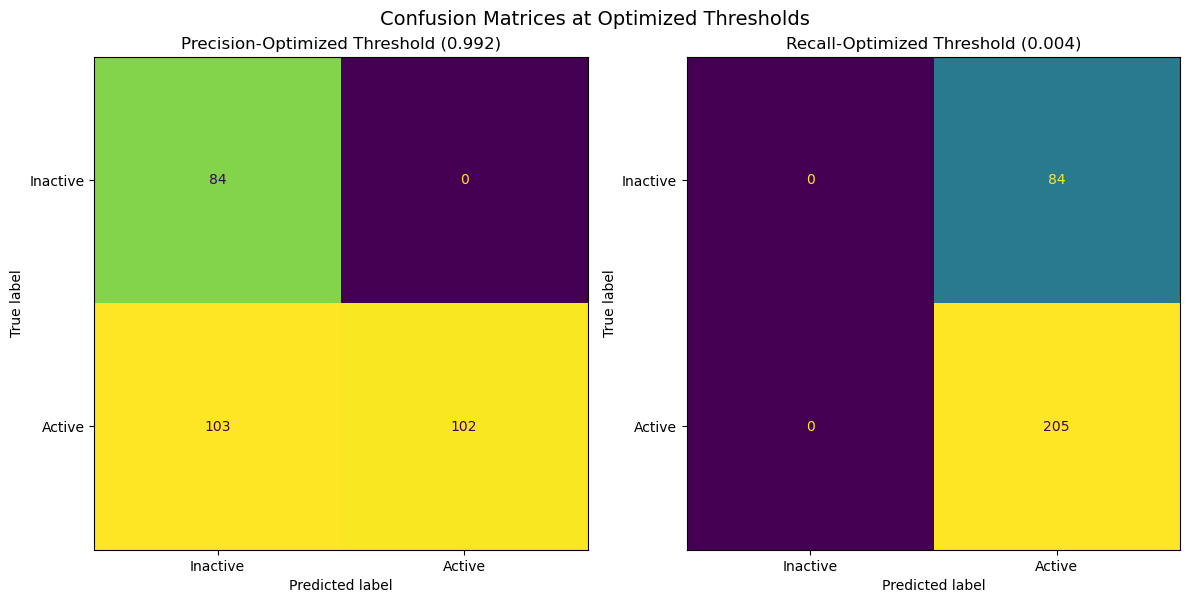

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

# Predictions at each optimized threshold
y_pred_precision = (y_proba_opt >= precision_thresh).astype(int)
y_pred_recall = (y_proba_opt >= recall_thresh).astype(int)

# Make the plots side by side this time
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

# Plot Precision-Optimized Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_precision,
    display_labels = ["Inactive", "Active"],
    ax = axs[0],
    colorbar = False
)
axs[0].set_title(f"Precision-Optimized Threshold ({precision_thresh:.3f})")

# Plot Recall-Optimized Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_recall,
    display_labels = ["Inactive", "Active"],
    ax = axs[1],
    colorbar = False
)
axs[1].set_title(f"Recall-Optimized Threshold ({recall_thresh:.3f})")

plt.suptitle("Confusion Matrices at Optimized Thresholds", fontsize = 14)
plt.tight_layout()
plt.show()

#### Confusion Matrix Interpretation

The confusion matrices summarize classification performance at the precision-optimized and recall-optimized thresholds:

**Precision-Optimized Threshold (~0.981)**:

-102 active molecules correctly identified (True Positives).

-84 inactive molecules correctly rejected (True Negatives).

-103 active molecules missed (False Negatives) due to strice thresholding.

-0 inactive molecules incorrectly classified as active (False Positives).

**Recall-Optimized Threshold (~0.012)**:

-205 active molecules correctly identified (True Positives).

-0 active molecules missed (False Negatives).

-84 inactive molecules incorrectly classified as active (False Positives).

The precision-optimized threshold achieves a highly pure shortlist at the cost of reduced recall, aligning with the business goal of minimizing experimental waste in early-stage compound screening.

#### Now let's just save our threshold with our predicted active values for use in the next notebook.

In [12]:
# set path
threshold_path = Path("../artifacts/thresholds/phase1_thresholds.json").resolve()
threshold_path.parent.mkdir(parents = True, exist_ok = True) # ensure folder exists

# save threshold
threshold_data = {"precision_optimized_threshold": float(precision_thresh)}

with open(threshold_path, "w") as f:
    json.dump(threshold_data, f, indent = 4)

# confirm
print("Threshold saved to:", threshold_path)

Threshold saved to: /home/ryanm/BioPred_DS/artifacts/thresholds/phase1_thresholds.json


### Summary

#### In this notebook, we:

- Trained and evaluated 10 different classification models, using ROC AUC as the primary performance metric.
- Identified LightGBM as the best-performing base model, achieving a ROC AUC score of 0.943.
- Optimized the LightGBM model using Bayesian Optimization with Optuna to further explore hyperparameter space.
- Final optimized LightGBM model achieved a ROC AUC score of 0.9367, confirming its strong baseline performance while establishing definitive tuned parameters.
- Selected the precision-optimized threshold (~0.981) based on precision-recall tradeoffs aligned with early-stage compound triage goals.
- Generated key evaluation visualizations (Precision-Recall-F1 curves, confusion matrices) to fully understand model behavior at optimized thresholds.
- Saved the final optimized model ('.pkl') model outputs ('y_test', 'y_proba_opt') and decision threshold ('.json') for reproducability and downstream results analysis in Phase 1.

We are now in good position to transition into Phase 1 Results.

